In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
import math

import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed, BatchNormalization
from keras.callbacks import EarlyStopping

import datetime as dt

Using TensorFlow backend.


In [7]:
path = "C:/Users/OPTIMUSPRIME/Desktop/Studia/Magisterka/Faints-Prediction/"
BP_filename = "BP.csv"
HR_filename = "HR.csv"

train_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/training_set.txt").values.tolist()]
test_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/test_set.txt").values.tolist()]
validation_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/validation_set.txt").values.tolist()]
all_indices = train_indices + test_indices + validation_indices

In [8]:
BP_data = pd.read_csv(path + "DATA/" + BP_filename, low_memory=False)[all_indices]
HR_data = pd.read_csv(path + "DATA/" + HR_filename, low_memory=False)[all_indices]
labels = {col: BP_data[col].iloc[0] for col in BP_data}

BP_max_value = BP_data.iloc[1:].astype(np.float32).max().max()
BP_min_value = BP_data.iloc[1:].astype(np.float32).min().min()
HR_max_value = HR_data.iloc[1:].astype(np.float32).max().max()
HR_min_value = HR_data.iloc[1:].astype(np.float32).min().min()

BP_scaler = MinMaxScaler().fit(np.array([BP_min_value, BP_max_value]).reshape(-1,1))
HR_scaler = MinMaxScaler().fit(np.array([HR_min_value, HR_max_value]).reshape(-1,1))

BP_data_scaled = BP_data.iloc[1:].astype(np.float32).copy()
BP_data_scaled[all_indices] = BP_scaler.transform(BP_data_scaled[all_indices])

HR_data_scaled = HR_data.iloc[1:].astype(np.float32).copy()
HR_data_scaled[all_indices] = HR_scaler.transform(HR_data_scaled[all_indices])


def downsample_to(n, df, mean_window):
    new_df = pd.DataFrame()
    for col in df:
        data = df[col][1:]
#         data_temp = data.count()
        div = int(data.count() / n) - 1 # -1 bo jakies problemy sa ze avr_data po usrednieniu ma dlugosc < 200 i sa ujemne excessPoints
        avr_data = data.rolling(mean_window).mean()[::div]
        avr_data = [_ for _ in list(avr_data) if np.isnan(_) != True]
#         temp = len(avr_data)
        excess_points = len(avr_data) - n
        avr_data = avr_data[excess_points:]
        new_df[col] = pd.Series(avr_data)
#         print(f"TS {col} processing. Div: {div}. Excess points: {excess_points}. Dl: {temp}. data len: {data_temp}")
    return new_df

BP_data_scaled = downsample_to(200, BP_data_scaled, 50)
HR_data_scaled = downsample_to(200, HR_data_scaled, 50)

# BP_data_scaled = BP_data_scaled.rolling(20).mean()
# HR_data_scaled = HR_data_scaled.rolling(20).mean()

In [10]:
BP_data_scaled['187']

0      0.353293
1      0.353293
2      0.353293
3      0.353293
4      0.353293
5      0.353293
6      0.351770
7      0.344117
8      0.331279
9      0.318677
10     0.312990
11     0.318003
12     0.332993
13     0.341487
14     0.342031
15     0.340039
16     0.338581
17     0.340861
18     0.345839
19     0.343553
20     0.343161
21     0.343521
22     0.344264
23     0.348096
24     0.353705
25     0.353699
26     0.351981
27     0.345887
28     0.346284
29     0.348343
         ...   
170    0.290108
171    0.298735
172    0.296371
173    0.293441
174    0.293124
175    0.298004
176    0.310360
177    0.326255
178    0.338610
179    0.344868
180    0.351332
181    0.348657
182    0.346119
183    0.343805
184    0.339172
185    0.340573
186    0.348892
187    0.351241
188    0.355168
189    0.370597
190    0.383816
191    0.396989
192    0.404103
193    0.401538
194    0.394780
195    0.395706
196    0.392739
197    0.396319
198    0.394600
199    0.387927
Name: 187, Length: 200, 

In [15]:
def split(BP_data, HR_data):
    X = []
    y = []
    for col in BP_data:
        BP_HR_interval = []
        for BP_interval, HR_interval in zip(BP_data[col], HR_data[col]):
            BP_HR_interval.append([BP_interval, HR_interval])
        X.append(BP_HR_interval)
        if labels[col] == 'Synkope': label = [0., 1.] 
        else: label = [1., 0.]
        y.append(label)
    return np.array(X), np.array(y)

In [16]:
X_train, y_train = split(BP_data_scaled[train_indices], HR_data_scaled[train_indices])
X_test, y_test = split(BP_data_scaled[test_indices], HR_data_scaled[test_indices])
X_validation, y_validation = split(BP_data_scaled[validation_indices], HR_data_scaled[validation_indices])

In [17]:
y_train.shape

(153, 2)

In [18]:
X_train.shape

(153, 200, 2)

In [19]:
from vrae.vrae import VRAE
from torch.utils.data import TensorDataset
import torch

In [20]:
hidden_size = 90 # 30? 60?
hidden_layer_depth = 1 #2?
latent_length = 2 #10? 20?
batch_size = 32
learning_rate = 0.0005
n_epochs = 40 #20? 80?
dropout_rate = 0.2
optimizer = 'Adam'  # options: ADAM, SGD
cuda = False  # options: True, False
print_every = 30
clip = True  # options: True, False
max_grad_norm = 5
loss = 'MSELoss'  # options: SmoothL1Loss, MSELoss
block = 'LSTM'  # options: LSTM, GRU

In [21]:
train_dataset = TensorDataset(torch.from_numpy(X_train))
test_dataset = TensorDataset(torch.from_numpy(X_test))

In [22]:
sequence_length = X_train.shape[1]
number_of_features = X_train.shape[2]


vrae = VRAE(sequence_length=sequence_length,
            number_of_features=number_of_features,
            hidden_size=hidden_size,
            hidden_layer_depth=hidden_layer_depth,
            latent_length=latent_length,
            batch_size=batch_size,
            learning_rate=learning_rate,
            n_epochs=n_epochs,
            dropout_rate=dropout_rate,
            optimizer=optimizer,
            cuda=cuda,
            print_every=print_every,
            clip=clip,
            max_grad_norm=max_grad_norm,
            loss=loss,
            block=block,
            dload='a')


C:\Programs\Anaconda3\lib\site-packages\torch\nn\modules\rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
C:\Programs\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [23]:
vrae.fit(train_dataset)

Epoch: 0
Average loss: 2594.9594
Epoch: 1
Average loss: 1948.5771
Epoch: 2
Average loss: 1499.7313
Epoch: 3
Average loss: 958.8902
Epoch: 4
Average loss: 554.7973
Epoch: 5
Average loss: 274.9271
Epoch: 6
Average loss: 246.3865
Epoch: 7
Average loss: 252.6439
Epoch: 8
Average loss: 206.6506
Epoch: 9
Average loss: 198.9332
Epoch: 10
Average loss: 201.6829
Epoch: 11
Average loss: 199.8994
Epoch: 12
Average loss: 205.5419
Epoch: 13
Average loss: 210.9495
Epoch: 14
Average loss: 197.5004
Epoch: 15
Average loss: 198.5770
Epoch: 16
Average loss: 199.3347
Epoch: 17
Average loss: 191.4412
Epoch: 18
Average loss: 191.9276
Epoch: 19
Average loss: 211.4152
Epoch: 20
Average loss: 196.6121
Epoch: 21
Average loss: 198.0314
Epoch: 22
Average loss: 200.4317
Epoch: 23
Average loss: 194.6158
Epoch: 24
Average loss: 206.3772
Epoch: 25
Average loss: 203.3000
Epoch: 26
Average loss: 192.9134
Epoch: 27
Average loss: 204.3731
Epoch: 28
Average loss: 196.5241
Epoch: 29
Average loss: 197.1295
Epoch: 30
Average

In [24]:
def scale(x, out_range=(-1, 1), axis=None):
    domain = np.min(x, axis), np.max(x, axis)
    y = (x - (domain[1] + domain[0]) / 2) / (domain[1] - domain[0])
    return y * (out_range[1] - out_range[0]) + (out_range[1] + out_range[0]) / 2

scale([1,2,3,4,5], (0,100))

array([  0.,  25.,  50.,  75., 100.])

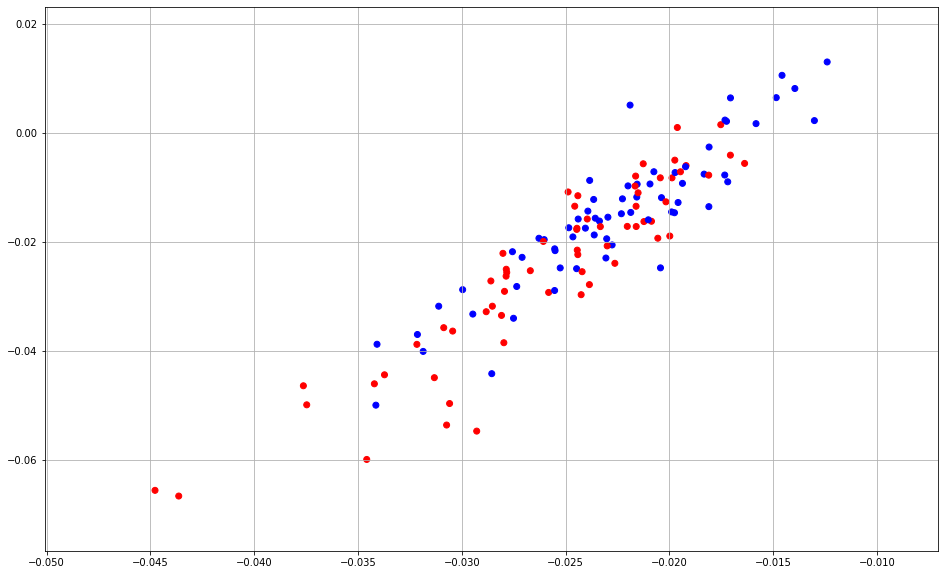

In [27]:
def choose_color(label):
    if label[0] == 1.0:
        return 'r'
    elif label[0] == 0.0:
        return 'b'
    else:
        return 'm'

X_test_means = scale([np.mean(x[:,1]) for x in X_train], (0,100))
    
latent_space = None
def plot_latent_space(X, y):
    global latent_space 
    latent_space = vrae.transform(X)
    plt.figure(figsize=(16,10))
    colors = [choose_color(y) for y in y[:latent_space.shape[0]]]
    plt.scatter(latent_space[:, 0], latent_space[:, 1], c=colors)
    plt.grid()

plot_latent_space(train_dataset, y_train)

In [77]:
X_right_cluster = X_test[np.where(np.all([latent_space[:,1] > 1.0, latent_space[:,1] < 2.0], axis=0))]
X_center_cluster = X_test[np.where(np.all([latent_space[:,1] > -1.0, latent_space[:,1] < 0.0, latent_space[:,0] < 0.0], axis=0))]
X_left_cluster = X_test[np.where(np.all([latent_space[:,1] > -5.0, latent_space[:,1] < -2.4], axis=0))]

In [80]:
def plot_single_time_series(timeseries_list, n=1, color='r'):
    for i in range(n):
        timeseries = timeseries_list[i]
        BP = timeseries[:,0]
#         HR = timeseries[:,1]
#         plt.figure()
        plt.plot(range(len(BP)), BP, c=color)
#         plt.plot(range(len(BP)), HR)    

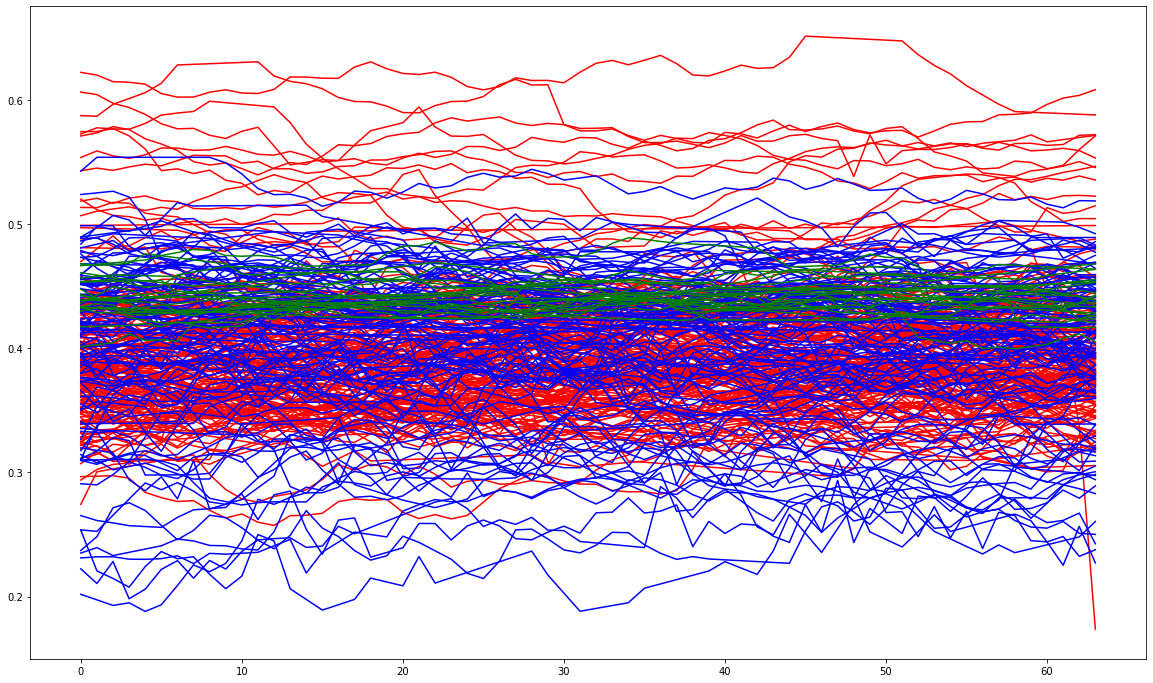

In [81]:
plt.figure(figsize=(20,12))
plot_single_time_series(X_right_cluster, len(X_right_cluster), 'r')
plot_single_time_series(X_center_cluster, len(X_center_cluster), 'b')
plot_single_time_series(X_left_cluster, len(X_left_cluster), 'g')

In [92]:
X_test_means = [np.mean(x[:,1]) for x in X_test]


In [91]:
b

[0.44066720735281706,
 0.4523748839274049,
 0.5221869545057416,
 0.5233332626521587,
 0.5288475034758449,
 0.5266033792868257,
 0.5281483121216297,
 0.5269829574972391,
 0.5269681233912706,
 0.5225128526799381,
 0.5365427918732166,
 0.5366882821545005,
 0.5241289688274264,
 0.5271820211783051,
 0.5334396259859204,
 0.5346467047929764,
 0.5579027468338609,
 0.5344391968101263,
 0.5214026235044003,
 0.5046842657029629,
 0.47767045395448804,
 0.4439638573676348,
 0.4295659023337066,
 0.41089877486228943,
 0.4237608606927097,
 0.38583250530064106,
 0.424941161647439,
 0.44146977039054036,
 0.4168103155680001,
 0.37915183510631323,
 0.3935253000818193,
 0.3943698783405125,
 0.3938296274282038,
 0.3840669859200716,
 0.41033405251801014,
 0.3961609536781907,
 0.3775306665338576,
 0.38728470355272293,
 0.38905854197219014,
 0.4005677620880306,
 0.3969476269558072,
 0.4087176416069269,
 0.40264573227614164,
 0.4108036356046796,
 0.3966696998104453,
 0.3868255433626473,
 0.4118432328104973,
 0.3

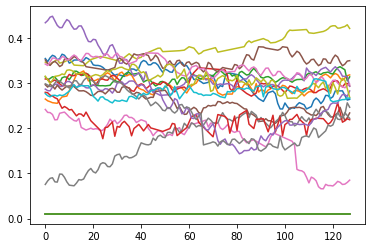

In [128]:
plot_single_time_series(X_left_cluster, 20)